In [1]:
import cv2 as cv
import numpy as np
import os
import pandas as pd
from numpy import linalg as LA
import csv


**Hàm trích chọn đặc trưng màu sắc của ảnh**

In [2]:
def histogram(image, mask=None):
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hist = cv.calcHist([image], [0,1,2], None, [8, 12, 3], [0, 256, 0, 256, 0, 256])
    cv.normalize(hist, hist)
    return hist.flatten()

**Hàm trích chọn đặc trưng HOG của ảnh**

In [3]:
def hog(img_gray, cell_size=8, block_size=2, bins=9):
    img = img_gray
    h, w = img.shape # 128, 64
    
    # gradient
    xkernel = np.array([[-1, 0, 1]])
    ykernel = np.array([[-1], [0], [1]])
    dx = cv.filter2D(img, cv.CV_32F, xkernel)
    dy = cv.filter2D(img, cv.CV_32F, ykernel)
    
    # histogram
    magnitude = np.sqrt(np.square(dx) + np.square(dy))
    orientation = np.arctan(np.divide(dy, dx+0.00001)) # radian
    orientation = np.degrees(orientation) # -90 -> 90
    orientation += 90 # 0 -> 180
    
    num_cell_x = w // cell_size # 8
    num_cell_y = h // cell_size # 16
    hist_tensor = np.zeros([num_cell_y, num_cell_x, bins]) # 16 x 8 x 9
    for cx in range(num_cell_x):
        for cy in range(num_cell_y):
            ori = orientation[cy*cell_size:cy*cell_size+cell_size, cx*cell_size:cx*cell_size+cell_size]
            mag = magnitude[cy*cell_size:cy*cell_size+cell_size, cx*cell_size:cx*cell_size+cell_size]
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html
            hist, _ = np.histogram(ori, bins=bins, range=(0, 180), weights=mag) # 1-D vector, 9 elements
            hist_tensor[cy, cx, :] = hist
        pass
    pass
    
    # normalization
    redundant_cell = block_size-1
    feature_tensor = np.zeros([num_cell_y-redundant_cell, num_cell_x-redundant_cell, block_size*block_size*bins])
    for bx in range(num_cell_x-redundant_cell): # 7
        for by in range(num_cell_y-redundant_cell): # 15
            by_from = by
            by_to = by+block_size
            bx_from = bx
            bx_to = bx+block_size
            v = hist_tensor[by_from:by_to, bx_from:bx_to, :].flatten() # to 1-D array (vector)
            feature_tensor[by, bx, :] = v / LA.norm(v, 2)
            # avoid NaN:
            if np.isnan(feature_tensor[by, bx, :]).any(): # avoid NaN (zero division)
                feature_tensor[by, bx, :] = v
    
    return feature_tensor.flatten() # 3780 features

**Hàm miêu cả đặc trưng mà sắc cho ảnh**

In [4]:
def describe_histogram(image):
        features = []

        img = cv.cvtColor(image, cv.COLOR_BGR2HSV)

        (h, w) = img.shape[:2]
        (cX, cY) = (int(w * 0.5), int(h * 0.5))
        segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
                    (0, cX, cY, h)]

        (axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
        ellipMask = np.zeros(img.shape[:2], dtype="uint8")
        cv.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
        for (startX, endX, startY, endY) in segments:

            cornerMask = np.zeros(img.shape[:2], dtype="uint8")
            cv.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
            cornerMask = cv.subtract(cornerMask, ellipMask)

            hist = histogram(img, cornerMask)
            features.extend(hist)

        hist = histogram(img, ellipMask)
        features.extend(hist)

        return features

**Hàm miêu tả đặc trưng HOG cho ảnh**

In [5]:
def describeImage(image):
    image = cv.resize(image, dsize=(64, 128))

    hog_f = hog(image)
    
    features = np.hstack([hog_f])
    return features

**Hàm tìm kiếm ảnh dựa trên màu sắc**

In [6]:
def search_by_color(queryFeatures, path, limit=11):
        results = {}
        with open("color.csv") as f:

            reader = csv.reader(f)
            i = 0
            for row in reader:                
                if i > 0:
                    if row[0] == path:
                        features2 = [float(value) for value in row[2: ]]
                        d = chi2_distance(queryFeatures, features2)
                        results[row[1]] = d
                i+=1
            f.close()

        results = sorted([(v, k) for (k, v) in results.items()])

        return results[1:limit]

**Hàm tính khoảng cách dữ liệu màu sắc giữa ảnh truy vấn và ảnh trong CSDL**

In [7]:
def chi2_distance(histA, histB, esps=1e-10):
        d = 0.5 * np.sum([((a - b) ** 2 / (a + b + esps)) for (a, b) in zip(histA, histB)])
        return d

**Chương trình chính**

In [8]:
output_features= open('features.csv', "w")
output_colors = open('color.csv', 'w')

for label in os.listdir("101_ObjectCategories"):

    print(label, end=", ")

    for imageFile in os.listdir("101_ObjectCategories/" + label):
        if(imageFile.find('.jpg') != -1): 
            image = cv.imread("101_ObjectCategories/" + label + "/" + imageFile, cv.IMREAD_GRAYSCALE)
            image_ = cv.imread("101_ObjectCategories/" + label + "/" + imageFile)

            imageID = label + "_" + imageFile.strip(".jpg")
            
            features = describeImage(image)
            colors = describe_histogram(image_)
            
            features_ = [str(value) for value in features]
            colors_ = [str(value) for value in colors]
            
            output_features.write("%s, %s, %s\n" % (label, imageID,  ",".join(features_)))
            output_colors.write("%s, %s, %s\n" % (label, imageID,  ",".join(colors_)))

output_features.close()
output_colors.close()

.ipynb_checkpoints, accordion, 

C:\Users\CINTER~1\AppData\Local\Temp/ipykernel_17300/1941289294.py:40: RuntimeWarning: invalid value encountered in true_divide
  feature_tensor[by, bx, :] = v / LA.norm(v, 2)


airplanes, anchor, ant, barrel, bass, beaver, binocular, bonsai, brain, brontosaurus, buddha, butterfly, camera, cannon, car_side, ceiling_fan, cellphone, chair, chandelier, cougar_body, cougar_face, crab, crayfish, crocodile, crocodile_head, cup, dalmatian, dollar_bill, dolphin, dragonfly, electric_guitar, elephant, emu, euphonium, ewer, Faces, Faces_easy, ferry, flamingo, flamingo_head, garfield, gerenuk, gramophone, grand_piano, hawksbill, headphone, hedgehog, helicopter, ibis, inline_skate, joshua_tree, kangaroo, ketch, lamp, laptop, Leopards, llama, lobster, lotus, mandolin, mayfly, menorah, metronome, minaret, Motorbikes, nautilus, octopus, okapi, pagoda, panda, pigeon, pizza, platypus, pyramid, revolver, rhino, rooster, saxophone, schooner, scissors, scorpion, sea_horse, snoopy, soccer_ball, stapler, starfish, stegosaurus, stop_sign, strawberry, sunflower, tick, trilobite, umbrella, watch, water_lilly, wheelchair, wild_cat, windsor_chair, wrench, yin_yang, 

**Thêm header cho file features**

In [9]:
df = pd.read_csv('features.csv', header=None)
col_num = len(df.columns)
header = ['category', 'id']

for i in range(col_num - 2):
    header.append('x' + str(i))

df.to_csv('features.csv', header=header, index=False)



**Lọc dữ liệu cho các features, mã hóa cho tập label**

In [10]:
df = pd.read_csv('features.csv')

from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()

df['category_encode'] = lab.fit_transform(df['category'])
df = df.dropna()
df.head()

,category,id,x0,x1,x2,x3,x4,x5,x6,x7,...,x3771,x3772,x3773,x3774,x3775,x3776,x3777,x3778,x3779,category_encode
0,accordion,accordion_image_0001,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,accordion,accordion_image_0002,0.0,0.0,0.0,0.0,0.002111,0.0,0.002986,0.0,...,0.002131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,accordion,accordion_image_0003,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,accordion,accordion_image_0004,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,accordion,accordion_image_0005,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


**Tạo tập ánh xạ giữa label dạng chữ và dạng số**

In [11]:
mapping = pd.DataFrame()
mapping['category'] = df['category']
mapping['category_encode'] = df['category_encode']
mapping = mapping.loc[~mapping.category.duplicated(keep='first')]
mapping.reset_index(drop=True, inplace=True)
mapping.head(10)

,category,category_encode
0,accordion,4
1,airplanes,5
2,anchor,6
3,ant,7
4,barrel,8
5,bass,9
6,beaver,10
7,binocular,11
8,bonsai,12
9,brain,13


**Xác định tập input cho mô hình học máy**

In [12]:
input = df.drop(['category', 'category_encode', 'id'], axis='columns')
input.head()


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x3770,x3771,x3772,x3773,x3774,x3775,x3776,x3777,x3778,x3779
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.001014,...,0.003536,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.002111,0.0,0.002986,0.0,0.002111,0.040647,...,0.035209,0.002131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000949,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.219705,...,0.076772,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Xác định tập label cho mô hình học máy**

In [13]:
target = df['category_encode']
target.head()

0    4
1    4
2    4
3    4
4    4
Name: category_encode, dtype: int32

**Chia tập train, test cho mô hình học máy**

In [14]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(input, target, test_size=0.3)

**Training**

In [15]:
from sklearn.svm import SVC
svc_model = SVC(kernel='linear', C=100)
svc_model.fit(xtrain, ytrain)

import joblib
joblib.dump(svc_model, "new_model")

# from sklearn.model_selection import GridSearchCV

# parameter_candidates = [
#   {'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000], 'kernel': ['linear']},
# ]

# clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, n_jobs=-1)
# clf.fit(xtrain, ytrain)
# print('Best score:', clf.best_score_)
# print('Best C:',clf.best_estimator_.C)


['new_model']

In [16]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression();
logistic_model.fit(xtrain, ytrain)
import joblib
joblib.dump(logistic_model, "logisticRegressionModel")

C:\Users\cinterface\.conda\envs\cinterface\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


['logisticRegressionModel']

In [17]:
from sklearn.ensemble import RandomForestClassifier
randomForest_model = RandomForestClassifier();
randomForest_model.fit(xtrain, ytrain)
import joblib
joblib.dump(randomForest_model, "randomForestClassifierModel")

['randomForestClassifierModel']

**Kiểm tra độ chính xác**

In [18]:
import joblib
svc_model = joblib.load('new_model')
score = svc_model.score(xtest, ytest )
score


0.6405529953917051

In [19]:
import joblib
logistic_model = joblib.load('logisticRegressionModel')
score = logistic_model.score(xtest, ytest )
score

0.6367127496159755

In [20]:
import joblib
randomForest_model = joblib.load('RandomForestClassifierModel')
score = randomForest_model.score(xtest, ytest )
score



0.43548387096774194

In [21]:
y_predict = svc_model.predict(xtest)
# Ma trận lỗi
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, y_predict)


array([[114,   2,   0, ...,   0,   0,   0],
       [  3, 143,   0, ...,   0,   0,   0],
       [  0,   0,  59, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  13,   0,   0],
       [  0,   0,   0, ...,   0,   7,   0],
       [  0,   0,   1, ...,   0,   0,  19]], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_predict)



0.6405529953917051

In [23]:
import matplotlib.pyplot as plt


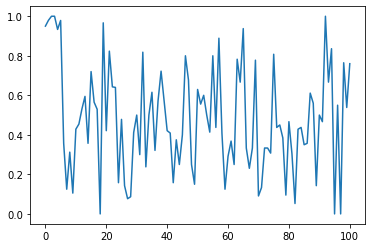

In [24]:
#Recall
from sklearn.metrics import recall_score
recallScore_svc = recall_score(ytest, y_predict, average=None)
plt.plot(recallScore_svc)

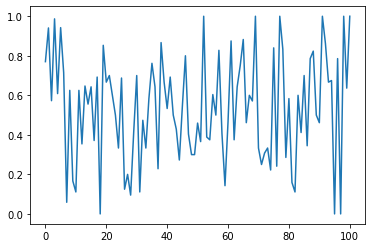

In [25]:
# Precision
from sklearn.metrics import precision_score
precisionScore_svc = precision_score(ytest, y_predict, average=None)
plt.plot(precisionScore_svc)

In [26]:
from sklearn.metrics import f1_score
f1Score_svc = f1_score(ytest, y_predict, average=None)

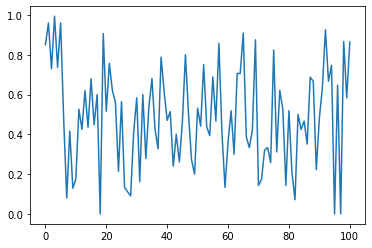

In [27]:
plt.plot(f1Score_svc)


In [28]:
y_predict = logistic_model.predict(xtest)
# Ma trận lỗi
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, y_predict)

array([[113,   1,   0, ...,   0,   0,   0],
       [  0, 146,   0, ...,   0,   0,   0],
       [  0,   0,  57, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  14,   0,   0],
       [  0,   0,   0, ...,   0,   7,   0],
       [  0,   0,   1, ...,   0,   0,  18]], dtype=int64)

**Bắt đầu thực hiện truy vấn ảnh**
**Dự đoán label cho ảnh**

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_predict)

0.6367127496159755

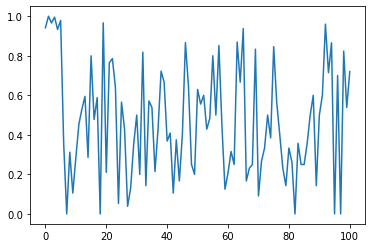

In [30]:
#Recall
from sklearn.metrics import recall_score
recallScore_logistic = recall_score(ytest, y_predict, average=None)
plt.plot(recallScore_logistic)

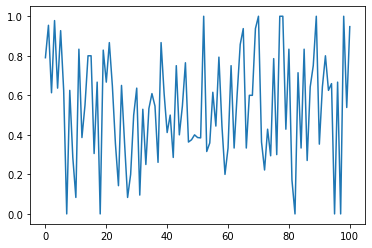

In [31]:
# Precision
from sklearn.metrics import precision_score
precisionScore_logistic = precision_score(ytest, y_predict, average=None)
plt.plot(precisionScore_logistic)

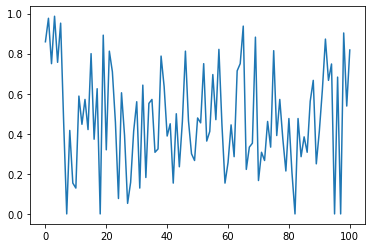

In [32]:
from sklearn.metrics import f1_score
f1Score_logistic = f1_score(ytest, y_predict, average=None)
plt.plot(f1Score_logistic)


In [33]:
y_predict = randomForest_model.predict(xtest)
# Ma trận lỗi
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, y_predict)

array([[118,   2,   0, ...,   0,   0,   0],
       [  0, 146,   0, ...,   0,   0,   0],
       [  0,   0,  59, ...,   0,   0,   0],
       ...,
       [  4,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   7,   0],
       [  2,   0,   1, ...,   0,   0,  14]], dtype=int64)

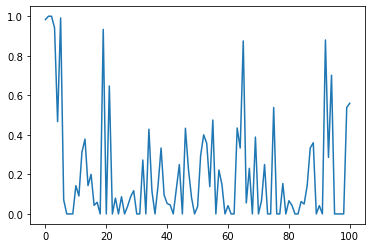

In [34]:
#Recall
from sklearn.metrics import recall_score
recallScore_randomForest = recall_score(ytest, y_predict, average=None)
plt.plot(recallScore_randomForest)

C:\Users\cinterface\.conda\envs\cinterface\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


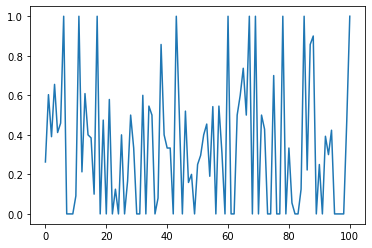

In [35]:
# Precision
from sklearn.metrics import precision_score
precisionScore_randomForest = precision_score(ytest, y_predict, average=None)
plt.plot(precisionScore_randomForest)

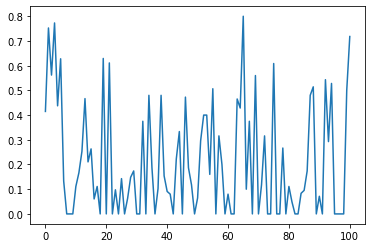

In [36]:
from sklearn.metrics import f1_score
f1Score_randomForest = f1_score(ytest, y_predict, average=None)
plt.plot(f1Score_randomForest)

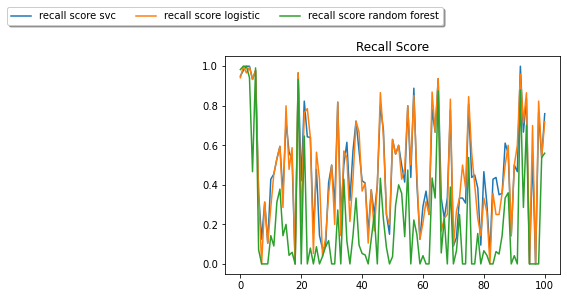

In [37]:
plt.plot(recallScore_svc, label="recall score svc")
plt.plot(recallScore_logistic, label="recall score logistic")
plt.plot(recallScore_randomForest, label="recall score random forest")

# plt.legend(loc = 'upper right')
plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25),
          ncol=3, fancybox=True, shadow=True)
plt.title('Recall Score')
plt.show()

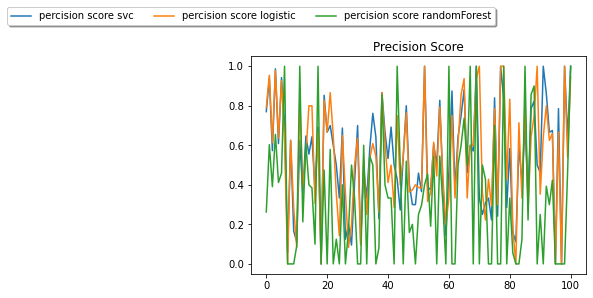

In [38]:
plt.plot(precisionScore_svc, label="percision score svc")
plt.plot(precisionScore_logistic, label="percision score logistic")
plt.plot(precisionScore_randomForest, label="percision score randomForest")

# plt.legend(loc = 'upper right')
plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25),
          ncol=3, fancybox=True, shadow=True)
plt.title('Precision Score')
plt.show()

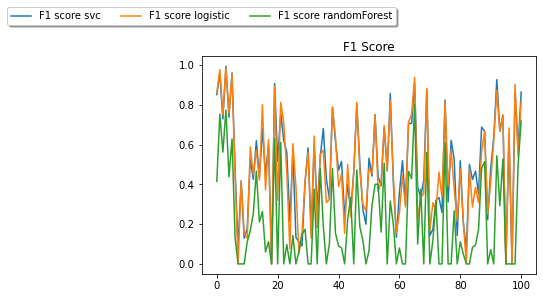

In [39]:
plt.plot(f1Score_svc, label="F1 score svc")
plt.plot(f1Score_logistic, label="F1 score logistic")
plt.plot(f1Score_randomForest, label="F1 score randomForest")

# plt.legend(loc = 'upper right')
plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25),
          ncol=3, fancybox=True, shadow=True)
plt.title('F1 Score')
plt.show()

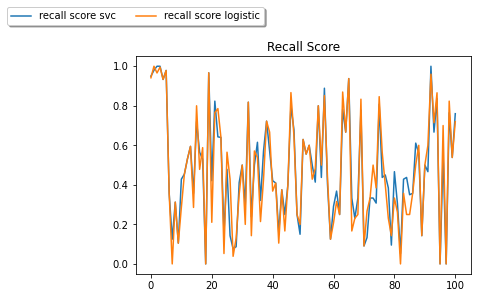

In [40]:
plt.plot(recallScore_svc, label="recall score svc")
plt.plot(recallScore_logistic, label="recall score logistic")

# plt.legend(loc = 'upper right')
plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25),
          ncol=2, fancybox=True, shadow=True)
plt.title('Recall Score')
plt.show()

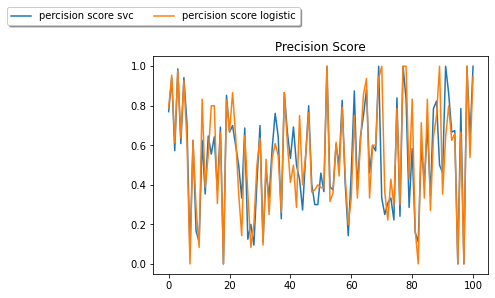

In [41]:
plt.plot(precisionScore_svc, label="percision score svc")
plt.plot(precisionScore_logistic, label="percision score logistic")

# plt.legend(loc = 'upper right')
plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25),
          ncol=2, fancybox=True, shadow=True)
plt.title('Precision Score')
plt.show()

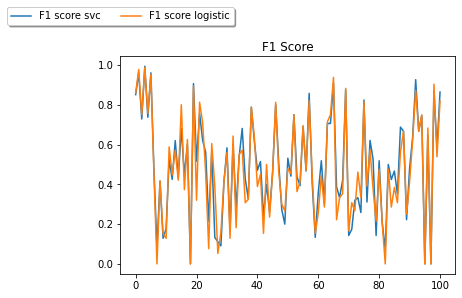

In [42]:
plt.plot(f1Score_svc, label="F1 score svc")
plt.plot(f1Score_logistic, label="F1 score logistic")

# plt.legend(loc = 'upper right')
plt.legend(loc='upper center', bbox_to_anchor=(0, 1.25),
          ncol=2, fancybox=True, shadow=True)
plt.title('F1 Score')
plt.show()

**Thực hiện truy vấn hình ảnh**

In [43]:
import time
start = time.time()

path_query = "query/brain_image_0095.jpg"

image = cv.imread(path_query, cv.IMREAD_GRAYSCALE)
image_ = cv.resize(image, dsize=(64, 128))


features = describeImage(image_)
            
label = svc_model.predict([features])[0]

C:\Users\cinterface\.conda\envs\cinterface\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [44]:
path = ""
for index, row in mapping.iterrows():
    if int(row['category_encode']) == label:
        path = row['category']
        break;
path

'binocular'

**Thực hiện tính toán khoảng cách dữ liệu màu sắc cho ảnh truy vấn với tập ảnh trong csdl có cùng label**

In [45]:
image = cv.imread(path_query)
results = search_by_color(describe_histogram(image), path)
print(results)

[(1.864616449999859, ' binocular_image_0032'), (1.9340370964853002, ' binocular_image_0022'), (3.3124889320698747, ' binocular_image_0021'), (3.621720733520599, ' binocular_image_0005'), (3.6258866793823037, ' binocular_image_0008'), (3.9665438153675585, ' binocular_image_0029'), (4.563769185311244, ' binocular_image_0013'), (4.567740277055844, ' binocular_image_0010'), (4.571915458755542, ' binocular_image_0012'), (4.5794111906135795, ' binocular_image_0031')]


**Trả về kết quả truy vấn: thời gian truy vấn, hình ảnh, độ chính xác**

Ảnh truy vấn:



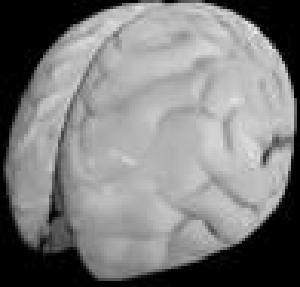







Thời gian tìm kiếm: 2.8042399883270264
Tập ảnh kết quả:

d=: 1.864616449999859


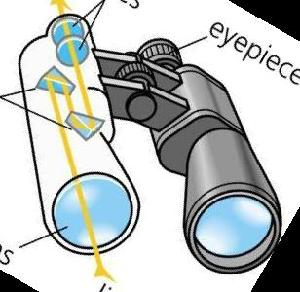



d=: 1.9340370964853002


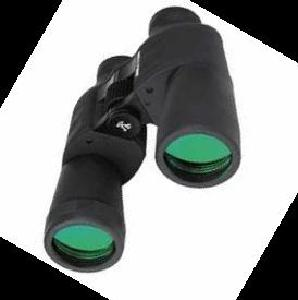



d=: 3.3124889320698747


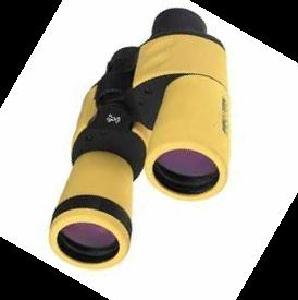



d=: 3.621720733520599


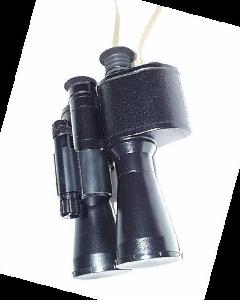



d=: 3.6258866793823037


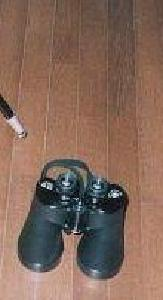



d=: 3.9665438153675585


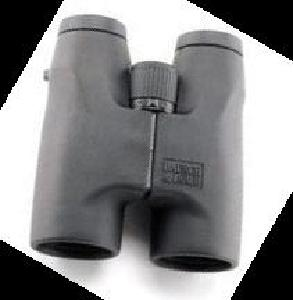



d=: 4.563769185311244


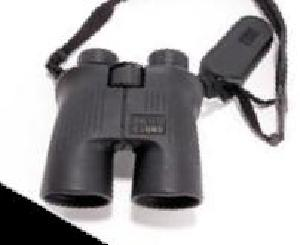



d=: 4.567740277055844


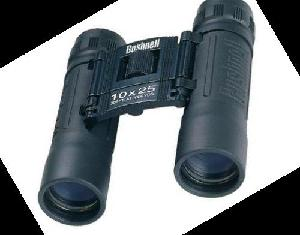



d=: 4.571915458755542


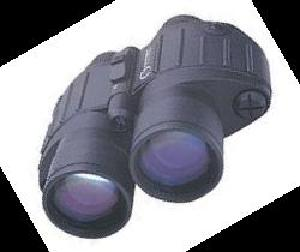



d=: 4.5794111906135795


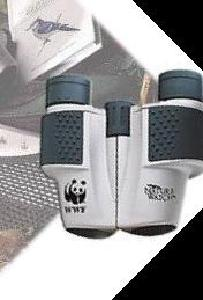

In [46]:
from IPython.display import Image
from IPython.display import display

import time

print("Ảnh truy vấn:\n")
display(Image(path_query))
print("\n\n\n\n\n")


total_time = time.time() - start
print("Thời gian tìm kiếm: " + str(total_time));
print("Tập ảnh kết quả:\n")
for (score, resultID) in results:
        location = "101_ObjectCategories/" + resultID.replace("_image", "/image").strip() + ".jpg"
        print("d=: " + str(score))
        x = Image(filename=location)
        display(x)
        print("\n")
